In [1]:
import pandas as pd

# Load the dataset
train = pd.read_csv("../data/train.csv")

In [2]:
# Lade den Kaggle Test Datensatz
# Dieser muss zusammen mit dem Trainingsdatensatz verarbeitet werden, sonst fehlen einige Spalten im Kaggle Testdatensatz!
X_test_kaggle = pd.read_csv("../data/test.csv")
_X_test_kaggle = X_test_kaggle.copy()

X_test_kaggle["Survived"] = 0 # Dummy damit Pandas keine Zicken macht
X_test_kaggle["IsKaggleTestData"] = True

In [3]:
def transform_data(df:pd.DataFrame):
    # Now the names...
    # First, seperate the first and last name
    df[["LastName", "FirstName_tmp"]] = df["Name"].str.split(",", expand=True)
    
    # Now the salutation forms
    df[["SalutForm","FirstName"]] = df["FirstName_tmp"].str.split(".", n=1, expand=True)
    
     # Grouping age
    group_limits = [0, 10, 20, 30, 40, 50 , 60, 70, 100]
    groups = [0, 1, 2, 3, 4, 5, 6, 7]
    df["AgeGroup"] = pd.cut(df['Age'], bins=group_limits, labels=groups)
    
    # Grouping family size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    group_limits = [0, 1, 3, 7, 100]
    groups = [0, 1, 2, 3]
    df["FamilySize"] = pd.cut(df['Age'], bins=group_limits, labels=groups)
    
    df = df.drop([
        "PassengerId",
        "FirstName_tmp",
        "FirstName",
        "LastName",
        "Name",
        "Cabin",
        "Ticket"], axis=1)
                              
    return df

In [4]:
train = transform_data(train)
X_test_kaggle = transform_data(X_test_kaggle)
train["IsKaggleTestData"] = False

In [5]:
df = pd.concat([train, X_test_kaggle], axis=0)

In [6]:
num_cols = ["Age", "SibSp", "Parch", "Fare"]
cat_cols = ["Pclass", "Sex", "Embarked", "SalutForm", "FamilySize", "AgeGroup"]
dist_col = ["IsKaggleTestData"]

In [7]:
# Define pipelines and preprocessor
from sklearn import (compose, impute, linear_model, preprocessing)
from sklearn.pipeline import Pipeline

numerical_preprocessor = Pipeline(steps=[
    ("imputer", impute.SimpleImputer(strategy="mean")),
    ("scaler", preprocessing.StandardScaler())
])

categorical_preprocessor = Pipeline(steps=[
    ("imputer", impute.SimpleImputer(strategy="most_frequent")),
    ("onehot", preprocessing.OneHotEncoder(handle_unknown="error", sparse_output=False)),
])

preprocessor = compose.ColumnTransformer(
    transformers=[
        ("numerical", numerical_preprocessor, num_cols),
        ("categorical", categorical_preprocessor, cat_cols),
        ("passthrough", "passthrough", dist_col)
    ]
)

In [8]:
# Split the data

y = df[["Survived","IsKaggleTestData"]]
X = df.drop(["Survived"], axis=1)

In [9]:
# Preprocess the data
preprocessor.set_output(transform="pandas")
X_pipe = preprocessor.fit_transform(X)

In [10]:
X_test_kaggle_pipe = X_pipe.loc[X_pipe["passthrough__IsKaggleTestData"] == True]
X_test_kaggle_pipe = X_test_kaggle_pipe.drop(["passthrough__IsKaggleTestData"], axis = 1)

In [11]:
X_test_kaggle_pipe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 42 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   numerical__Age                        418 non-null    float64
 1   numerical__SibSp                      418 non-null    float64
 2   numerical__Parch                      418 non-null    float64
 3   numerical__Fare                       418 non-null    float64
 4   categorical__Pclass_1                 418 non-null    float64
 5   categorical__Pclass_2                 418 non-null    float64
 6   categorical__Pclass_3                 418 non-null    float64
 7   categorical__Sex_female               418 non-null    float64
 8   categorical__Sex_male                 418 non-null    float64
 9   categorical__Embarked_C               418 non-null    float64
 10  categorical__Embarked_Q               418 non-null    float64
 11  categorical__Embark

In [12]:
X_train_full_pipe = X_pipe.loc[X_pipe["passthrough__IsKaggleTestData"] == False]
X_train_full_pipe = X_train_full_pipe.drop(["passthrough__IsKaggleTestData"], axis = 1)

In [13]:
X_train_full_pipe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 42 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   numerical__Age                        891 non-null    float64
 1   numerical__SibSp                      891 non-null    float64
 2   numerical__Parch                      891 non-null    float64
 3   numerical__Fare                       891 non-null    float64
 4   categorical__Pclass_1                 891 non-null    float64
 5   categorical__Pclass_2                 891 non-null    float64
 6   categorical__Pclass_3                 891 non-null    float64
 7   categorical__Sex_female               891 non-null    float64
 8   categorical__Sex_male                 891 non-null    float64
 9   categorical__Embarked_C               891 non-null    float64
 10  categorical__Embarked_Q               891 non-null    float64
 11  categorical__Embark

In [14]:
y_train_full_pipe = y.loc[y["IsKaggleTestData"] == False]
y_train_full_pipe = y_train_full_pipe.drop(["IsKaggleTestData"], axis = 1)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_full_pipe, y_train_full_pipe, test_size=0.2)

In [16]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

resampler = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)

In [17]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=2, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

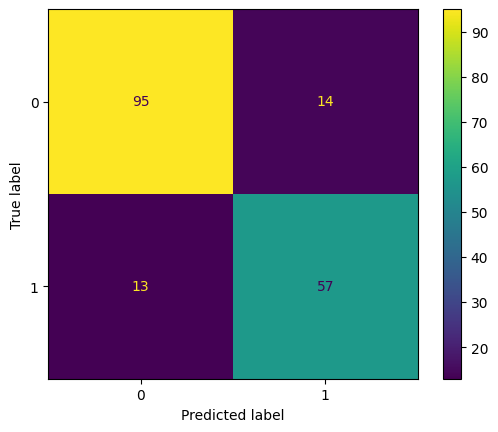

In [18]:
# Konfusionsmatrix und recall sowie precision
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_predict = model.predict(X_test)
cm = confusion_matrix(y_test, y_test_predict)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f"Accuracy: \t{accuracy_score(y_test, y_test_predict)}")
print(f"Precision: \t{precision_score(y_test, y_test_predict)}")
print(f"Recall: \t{recall_score(y_test, y_test_predict)}")
print(f"F1 Score: \t{f1_score(y_test, y_test_predict)}")

Accuracy: 	0.8491620111731844
Precision: 	0.8028169014084507
Recall: 	0.8142857142857143
F1 Score: 	0.8085106382978723


In [20]:
from datetime import datetime

preds_kaggle = model.predict(X_test_kaggle_pipe)
output = pd.DataFrame({"PassengerId": _X_test_kaggle["PassengerId"], "Survived": preds_kaggle})
output_path = f"../submissions/submsission {datetime.today().strftime('%Y-%m-%d %H_%M_%S')}.csv"
# output.to_csv(output_path, index=False)